In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_list = []
filename_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/ws23_processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/ws23_processed_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['resistance_depth_15.csv', 'resistance_depth_36.csv', 'resistance_depth_50.csv', 'resistance_depth_54.csv', 'resistance_depth_25.csv', 'resistance_depth_69.csv', 'resistance_depth_67.csv', 'resistance_depth_46.csv', 'resistance_depth_1.csv', 'resistance_depth_49.csv', 'resistance_depth_45.csv', 'resistance_depth_4.csv', 'resistance_depth_44.csv', 'resistance_depth_59.csv', 'resistance_depth_64.csv', 'resistance_depth_0.csv', 'resistance_depth_21.csv', 'resistance_depth_71.csv', 'resistance_depth_53.csv', 'resistance_depth_20.csv', 'resistance_depth_75.csv', 'resistance_depth_43.csv', 'resistance_depth_61.csv', 'resistance_depth_40.csv', 'resistance_depth_24.csv', 'resistance_depth_62.csv', 'resistance_depth_65.csv', 'resistance_depth_47.csv', 'resistance_depth_41.csv', 'resistance_depth_13.csv', 'resistance_depth_51.csv', 'resistance_depth_5.csv', 'resistance_depth_2.csv', 'resistance_depth_26.csv', 'resistance_depth_38.csv', 'resistance_depth_63.csv', 'resistance_depth_9.csv', 'resis

# Extract Features

In [16]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def plot_peaks(df, peaks):
    plt.figure(figsize=(4,3))         # Optional: set figure size
    # Plot the resistance curve
    plt.plot(df["depth"], df["resistance"])
    # Plot the peaks
    plt.plot(df["depth"].iloc[peaks], df["resistance"].iloc[peaks], 'ro', label="Peaks")
    plt.xlabel("Depth")
    plt.ylabel("Resistance")
    plt.title("Depth vs Resistance with Peaks")
    plt.legend()
    plt.show()

def remove_peak_if_close_to_end(peaks, df):
    len_depth = len(df['depth'])
    cleaned_peaks = []
    for peak in peaks:
        if peak < len_depth * 0.6: cleaned_peaks.append(int(peak))
    # if len(cleaned_peaks) == 0: cleaned_peaks.append(0.001)
    return cleaned_peaks

def make_peak_bool(peaks):
    if len(peaks) > 0: return 1
    else: return 0

def get_yield_force(df_list):
    peaks_list = []
    for df in df_list:
        # Find peaks in the resistance data
        # distance -> req minimal horiz dis in samples between neighboring peaks 
        # # this is an excellent combination
        peaks, _ = find_peaks(df["resistance"], height=0, distance=40, width=5)
        peaks = remove_peak_if_close_to_end(peaks, df)
        peaks = make_peak_bool(peaks)
        peaks_list.append(peaks)
    return peaks_list

peaks_list = get_yield_force(df_list)
# print(min(min(peaks_list)))

In [17]:

def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]
    return pd.DataFrame([{
        "res_mean": res.mean(),
        # "res_max": res.max(),
        "slope": res.max() / dep.max(),
        "depth_max": dep.max(),
    }])

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(df_list):
    extracted_simple_features = extract_simple_features(df)
    # print(df)
    # print(peaks_list[i])
    # extracted_simple_features["yield_force"] = peaks_list[i]
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")


example:    res_mean        slope  depth_max
0  9.181236  3354.996479   0.010987


# Correlation Matrix

In [18]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

           res_mean     slope  depth_max
res_mean   1.000000  0.513475  -0.648720
slope      0.513475  1.000000  -0.682138
depth_max -0.648720 -0.682138   1.000000


# Visualize Extracted Features Histograms

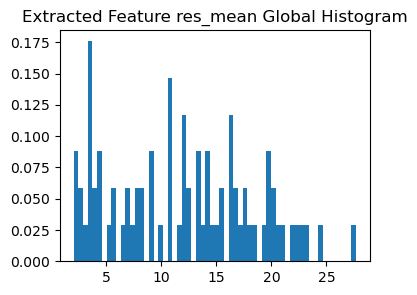

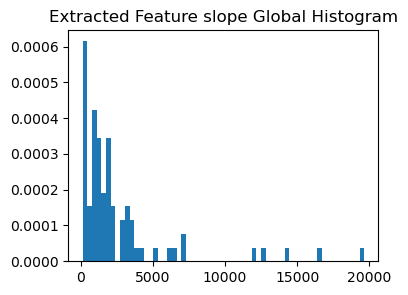

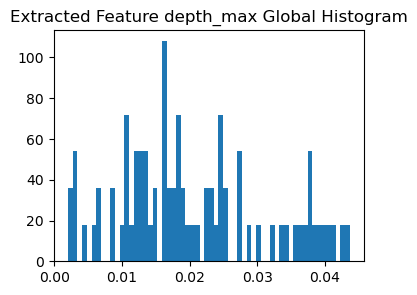

In [19]:
# representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
# # print(representation_df)
def plot_feature_dist(representation_df):
    for col in representation_df.columns:
        plt.figure(figsize=(4,3))
        plt.hist(representation_df[col], bins=60, density=True)
        plt.title(f"Extracted Feature {col} Global Histogram")
        plt.show()
plot_feature_dist(representation_df)

# Scale Features

   res_mean     slope  depth_max
0 -0.433934  0.771310  -0.855991
1 -1.062086 -0.378524  -0.397709
2  0.680835  2.345174  -1.675706
3 -0.804563 -0.312145   0.356622
4  0.025080 -0.300640   0.415958


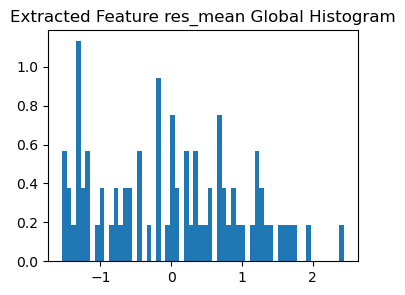

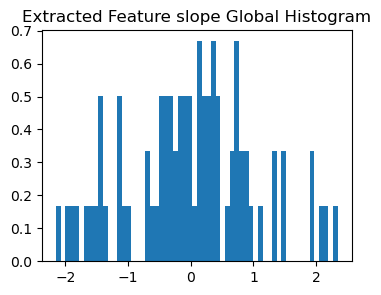

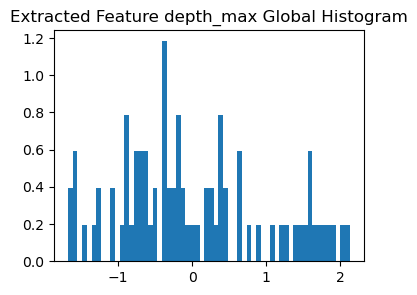

In [20]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "slope" in df.columns: df['slope'] = np.log(df['slope'])
    # if "yield_force" in df.columns: df['yield_force'] = df["yield_force"]
    # if "skew" in df.columns: df["skew"] = df["skew"] ** 1.1
    # if "kurtosis" in df.columns: df["kurtosis"] = np.sqrt(df["kurtosis"]) 
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
print(scaled_representations[:5])
plot_feature_dist(scaled_representations)


# Save representation

In [21]:
scaled_representations.to_csv(f"data/features.csv", index=False)